In [1]:
import jaxlib
from jax_unirep import get_reps
import pandas as pd
import os
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/home/mling13/miniconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Importing UniProt Data

In [2]:
# Importing secreted, cytoplasmic, and transmembrane proteins for human proteome
secreted = pd.read_csv('human_datasets/secreted.csv')
cytoplasm = pd.read_csv('human_datasets/cytoplasm.csv')
transmembrane = pd.read_csv('human_datasets/transmembrane.csv')

# Adding the class
secreted['Class'] = 'secreted'
cytoplasm['Class'] = 'cytoplasm'
transmembrane['Class'] = 'membrane'

# Concatenate df
human_data = pd.concat([secreted, cytoplasm, transmembrane])

# Importing a partial data set with unirep features
human_unirep_part = pd.read_csv('human_datasets/human_testing_data.csv')
human_unirep_part = human_unirep_part.drop(human_unirep_part.columns[[0]], axis=1)
human_unirep_part.head()

,ID,Class,Vec_0,Vec_1,Vec_2,Vec_3,Vec_4,Vec_5,Vec_6,Vec_7,...,Vec_1890,Vec_1891,Vec_1892,Vec_1893,Vec_1894,Vec_1895,Vec_1896,Vec_1897,Vec_1898,Vec_1899
0,Q8IWL1,secreted,0.001589,-0.088675,0.072082,-0.007780,-0.405418,0.004649,-0.142137,-0.046660,...,0.041924,0.071974,0.046500,0.009601,-0.215200,0.076984,0.037502,0.033136,0.131220,0.164174
1,Q8IWL2,secreted,0.001504,-0.091870,0.073000,-0.007296,-0.410786,0.007046,-0.139491,-0.044830,...,0.040061,0.070792,0.044514,0.007404,-0.211015,0.077411,0.037028,0.038521,0.115775,0.152708
2,P35247,secreted,-0.005619,0.155841,0.061187,-0.011045,-0.292977,0.001631,-0.166412,-0.047132,...,0.046157,0.061953,0.041291,0.000301,-0.183375,0.066759,0.061715,0.017694,0.341299,0.159945
3,Q9BQ16,secreted,0.003700,-0.170449,0.070491,-0.015611,-0.260699,-0.001906,-0.065601,-0.026869,...,-0.000768,-0.003258,0.042792,0.005990,-0.077984,0.026410,0.061212,-0.009403,-0.055176,-0.015667
4,Q9UBV4,secreted,0.003951,-0.022483,0.093345,-0.027903,-0.014826,0.063857,-0.009284,-0.064604,...,0.000366,-0.009532,-0.066172,-0.020427,-0.147530,0.080772,0.155460,-0.113068,-0.084242,0.020746


# Functions

In [3]:
def data_to_unirep(df):
    '''
    Generates a new data frame with the UniProt ID, UniRep 1900 vectors (x-values), and secretion state (y-values)
    
    Args:
        df (DataFrame): original data frame with sequence information and class information (specifying secretion)
        
    Returns:
        unirep_df (DataFrame): new unirep data frame with class information and unirep vectors
    '''
    seq_key = 'Sequence'
    vec_prefix = 'Vec_{}'
    
    # Generating new data frame with unirep vectors
    vec_column_names = [vec_prefix.format(i) for i in range(1900)]        
    unirep_df = pd.DataFrame(columns = ['Class'] + vec_column_names)

    for i, row in df.iterrows():
        if int(i) % 1 == 0:
            print('row {}'.format(i), end='\r')
        sequence = row.loc[seq_key]
        unirep_df.loc[i, 'Class'] = row['Class']
        vec = get_reps(sequence)[0][0]
        unirep_df.loc[i, vec_column_names] = vec
    
    return unirep_df

In [4]:
def classifier_comparison(X, y):
    '''
    Iterates through sklearn supervised learning classification models.
    Performs k-fold cross-validation (k=10).
    Comparing each classifier based on model accuracy.
    Plots model accuracy on a boxplot.
    Taken from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
    
    Args:
        X (Array-like): All of the input parameters (including UniRep vectors) for the secretion analysis model
        y (Array-like): The ouput parameter, or secretion class, for the secretion analysis model
        
    Returns:
        
    '''
    seed = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    # Preparing models
    models = []
    models.append(('RidgeReg', RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)))
    K_neighbors = int(np.sqrt(len(y_train)))
    models.append(('KNN', KNeighborsClassifier(K_neighbors, weights='uniform')))
    models.append(('NeuralNet', MLPClassifier(max_iter=200)))
    models.append(('RandomForest', RandomForestClassifier()))
    models.append(('RBF SVM', SVC(gamma=0.1, C=1)))
    
    # Evaluating each model using cross-validation
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
#         kfold = model_selection.KFold(n_splits=10, random_state=seed)
        kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    # Plotting the classifier comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [5]:
# Selecting the final models to build
def ridge_regression_classifier(X_train, X_test, y_train, y_test):
    '''
    Performs ridge regression classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: ridge regression classification model
    '''
    model = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)
    model.fit(X_train, y_train)
    return model

def knn_classifier(X_train, X_test, y_train, y_test):
    '''
    Performs K-nearest neighbors classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: K-nearest neighbors classification model
    '''
    K_neighbors = int(np.sqrt(len(y_train))) # set number of neighbors to square root of number of inputs
    model = KNeighborsClassifier(K_neighbors, weights='uniform')
    model.fit(X_train, y_train)
    return model

def neural_net_classifier(X_train, X_test, y_train, y_test):
    '''
    Performs MLP classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: MLP classification model (sklearn neural network)
    '''
    model = MLPClassifier(max_iter=200)
    model.fit(X_train, y_train)
    return model

def random_forest_classifier(X_train, X_test, y_train, y_test):
    '''
    Uses random forests to classify based on the given X and y values.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: random forest classification model
    '''
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

def rbf_svm_classifier(X_train, X_test, y_train, y_test):
    '''
    Uses rbf support vector machines to classify based on the given X and y values.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: rbf svm classficiation model
    '''
# Run the following in order to figure out the best C and gamma values!
#     C_range = np.logspace(-2, 10, 13)
#     gamma_range = np.logspace(-3, 3, 7)
#     for i in range(len(C_range)):
#     for j in range(len(gamma_range)):
#         model=SVC(gamma=gamma_range[j], C=C_range[i]).fit(X_train, y_train)
#         print("Gamma:", gamma_range[j], "C:", C_range[i], "Score:", model.score(X_test, y_test))
    model = SVC(gamma=0.1, C=1)
    model.fit(X_train, y_train)
    return model

In [6]:
def use_additional_features():
    #Use additional features to help improve the model. Check https://biopython.org/docs/1.75/api/Bio.SeqUtils.IsoelectricPoint.html

SyntaxError: unexpected EOF while parsing (<ipython-input-6-00efe1b162c0>, line 2)

In [14]:
def secretion_optimization_unirep(seq, pos, model):
    '''
    Based on the given model, this function mutates the input sequence at the position provided
    Uses only the unirep vectors as input values
    
    Args:
        seq (String): initial amino acid sequence provided with single-letter format
        pos (int): position where the mutations can occur in the given sequence
        model:
    
    Returns:
        seq (String): final, mutated amino acid sequence with improved secretion score
    '''
    # First, obtain the unirep representation of given sequence
    unirep_values = get_reps(seq)[0][0]
    unirep_values = unirep_values.reshape(1, -1)
    
    # Next, predict the initial secretion score
    print("The initial sequence is:", seq)
    initial_class = model.predict(unirep_values)
    print("The initial class is:", initial_class)
    classes = list(model.classes_)
    prediction_probability = list(model.predict_proba(unirep_values)[0]) # Grabbing the probability of each class
    initial_score = prediction_probability[classes.index('secreted')] # Grabbing the probability of being secreted class
    print("The initial probability of being the secreted class is:", initial_score)
    
    # Set up list of amino acids
    amino_acids = ['G', 'A', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H', 'R', 'N', 'D', 'T']
    
    # Set up point mutations
    mutated_scores_for_all_AA = []
    for i in range(len(amino_acids)):
        seq_list = list(seq)
        seq_list[pos] = amino_acids[i]
        new_seq = "".join(seq_list) # Creating the point-mutated sequence
        mutated_unirep_values = get_reps(new_seq)[0][0] # Grabbing the input parameters (unirep vectors)
        mutated_unirep_values = mutated_unirep_values.reshape(1, -1)
        mutated_class = model.predict(mutated_unirep_values) # The class of the mutated sequence
        classes = list(model.classes_)
        prediction_probability = list(model.predict_proba(mutated_unirep_values)[0])
        mutated_score = prediction_probability[classes.index('secreted')] # Grabbing the probability of being secreted class
        mutated_scores_for_all_AA.append(mutated_score)
        if mutated_score > initial_score:
            seq = new_seq
            initial_score = mutated_score
            initial_class = mutated_class
    print("The improved, mutated sequence is:", seq)
    print("The mutated class is:", initial_class)
    print("The mutated probability of being the secreted class is:", initial_score)
    
    plt.plot(amino_acids, mutated_scores_for_all_AA)
    plt.xlabel('Amino Acid Point Mutation')
    plt.ylabel('Probability of Class: Secreted (%)')
    plt.show()
            
    return seq

# Code and Analysis

In [8]:
# human_unirep = data_to_unirep(human_data)

RidgeReg: 0.972203 (0.004641)
KNN: 0.897933 (0.012692)
NeuralNet: 0.977415 (0.004476)
RandomForest: 0.970031 (0.006790)
RBF SVM: 0.967861 (0.004836)


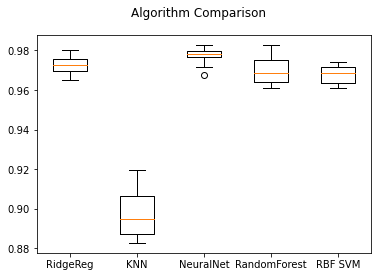

In [10]:
df2 = human_unirep_part.copy(deep=True)
df2.pop('Class') # Made a copy of the data set to drop the class in order for x-values to remain numerical
df2.pop('ID')
X = df2.values
y = np.array(human_unirep_part['Class'])

classifier_comparison(X, y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Using an example model to test out the secretion_optimization_unirep function
model = neural_net_classifier(X_train, X_test, y_train, y_test)

The initial sequence is: ACCAMGGSGCGSGSGSACCAMGGS
The initial class is: ['secreted']
The initial probability of being the secreted class is: 0.9960323190876071
The improved, mutated sequence is: ACCAMGGSGCPSGSGSACCAMGGS
The mutated class is: ['secreted']
The mutated probability of being the secreted class is: 0.9999511360147781


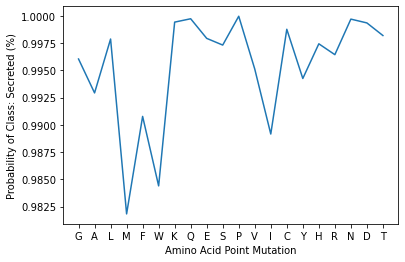

In [13]:
seq = 'ACCAMGGSGCGSGSGSACCAMGGS'
secretion_optimization_unirep(seq, 10, model)